# Predicting Movie Success using Posters
---
### Model:
    Deep Convolutional Neural Network

### Developers:

    Bardia Borhani  
    Kevin Ulrich

### Project Goals:
1. Create a working deep convolutional neural network
2. Train the network given posters from the [The Movies Dataset](https://www.kaggle.com/rounakbanik/the-movies-dataset)
3. See what performance can be achieved from model predictions given new posters
4. Bonus: Try out other models. Ensemble models.

# Setup Environment

We import numpy and pandas here for all our data processing needs, and then we specify the input location, and check what files are in the input folder.

In [54]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from print_head import head
from plot_images import show_images
import os

In [55]:
input_loc = '../input/movie_dataset'

print(os.listdir(input_loc))

['links_small.csv', 'the-movies-dataset.zip', 'ratings.csv', 'links.csv', 'keywords.csv', 'credits.csv', 'ratings_small.csv', 'movies_metadata.csv']


# Import Data

We then read in the data from the movies_metadata file. We output the first few rows of the file just to preview it.

In [56]:
metadata = pd.read_csv(input_loc + '/movies_metadata.csv', low_memory=False)

# preview the data
head(metadata, 3)

**whole table (below):** 45466 rows × 24 columns

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0


Continuing in the theme of checking our data, let's see all the header names, which helps us locate (loc or iloc) our data by column when we want to go through it row by row.

In [57]:
# what are the column names?
first_movie = metadata.iloc[[0]]
for key, value in first_movie.items() :
    print(key)

adult
belongs_to_collection
budget
genres
homepage
id
imdb_id
original_language
original_title
overview
popularity
poster_path
production_companies
production_countries
release_date
revenue
runtime
spoken_languages
status
tagline
title
video
vote_average
vote_count


# Bad Data
When we downloaded our data later in this script, we realized that there were a lot of posters that didn't have any extensions, and therefore were not images. Even appending an extension didn't make them work. Going back to the metadata csv, we realized that some of the rows simply don't have a poster path. Below is an example of a good row and a bad row.

In [58]:
# there are some movies that don't have posters... we'll deal with these later
print(str(metadata.iloc[[38802]]['poster_path']))
print(str(metadata.iloc[[44660]]['poster_path']))

38802    /sLvzxFBH5vGFei8oUNzDVwHKGdl.jpg
Name: poster_path, dtype: object
44660    NaN
Name: poster_path, dtype: object


# Scrape Posters

The script below scrapes all the posters from the TMDB website. Note that we are downloading the images with a set width of 780. Hopefully this will mean that all the posters will be the same size. Other sizes that we could do would be `w500` or `original`, just by replacing wherever `w780` appears in the script.

The only error checking we do is for illegal (NaN) poster paths. We exclude these from the dataset, and don't download the files. We also recreate our metadata DataFrame in memory to only include good data (rows with poster paths).

This script takes about 5 hours to download the ~45,000 posters at 780 width. I've heard things about using sessions with the requests library, but didn't care enough to look into it. If the dataset were larger, that might be a good idea.

In [59]:
# get all movie posters

# imports
import requests
import math
from tqdm import tqdm_notebook

# create a directory for the poster images to reside
poster_dir = 'poster_imgs/'
if not os.path.exists(poster_dir):
    os.makedirs(poster_dir)
    
good_metadata = []
# for each row of data
for index, row in tqdm_notebook(list(metadata.iterrows())):
    
    # build the file path
    posterpath = row['poster_path']
    if type(posterpath) != str or '.jpg' not in posterpath:
        # bad data, skip it
        pass
    else:
        filename = str(index) + '.jpg' # ignore the given file extension, it might be non-existent
        filepath = poster_dir + filename

        # if we haven't downloaded the file yet
        if not os.path.exists(filepath):

            # download the movie poster from tmdb using the poster path
            # and save it locally
            url = 'http://image.tmdb.org/t/p/w780' + posterpath
            r = requests.get(url, allow_redirects=True)
            open(filepath, 'wb').write(r.content)
            
        good_metadata.append(row)

print(len(metadata))
head(metadata, 3)
metadata = pd.DataFrame(good_metadata)        
print(len(metadata))
head(metadata, 3)

HBox(children=(IntProgress(value=0, max=45466), HTML(value='')))


45466


**whole table (below):** 45466 rows × 24 columns

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0


45069


**whole table (below):** 45069 rows × 24 columns

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0


# Load in the Data

Now that we've scraped the posters, it's time to load them into memory so we can give them to our neural network to train it.

The function we use to preview our images is from [here](https://gist.github.com/soply/f3eec2e79c165e39c9d540e916142ae1)

number of files in the poster directory:  45080
number of files in the poster directory that are jpgs:  45080
number of rows of metadata:  45069
number of images that we have in memory:  45080


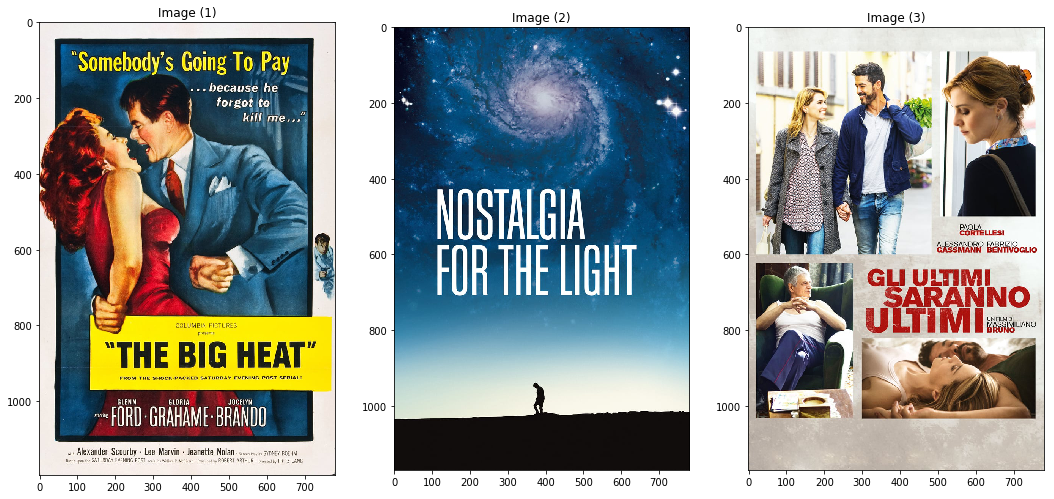

In [60]:
import skimage
import skimage.io as io
import skimage.transform
from skimage import data
import sys
%matplotlib inline


# read in filenames
files = []
for (dirpath, dirnames, filenames) in os.walk(poster_dir):
    files.extend(filenames)
    break
    
print('number of files in the poster directory: ', len(files))
    
# remove any of the files if they aren't jpgs
files = [ x for x in files if ".jpg" in x ]

print('number of files in the poster directory that are jpgs: ', len(files))

# prepend the filepath to the filenames
files = [(poster_dir + '{0}').format(i) for i in files]

# read in the images
images = io.imread_collection(list(files), conserve_memory=True)

# these lengths should be the same
print('number of rows of metadata: ', len(metadata))
print('number of images that we have in memory: ', len(images))

# show the first few posters to make sure we have the data
show_images(images[0:3]);

### Sidenote
Note that there's 9 posters of the dataset that are not jpgs. From a quick look at the data some of them - and probably all of them are pngs.